# Prediction with a pre-trained model (PyTorch)

This notebook demonstrates how to use a pre-trained 3D U-Net model to perform fault segmentation on new seismic data. It covers two scenarios:
1.  **Simple Prediction:** Running inference on a single data cube (e.g., from the validation set) to quickly check model performance.
2.  **Complex Prediction:** Running inference on a large field data volume that is bigger than the model's input size. This requires a tiling (or patching) approach with overlapping and blending to produce a smooth, final result.

## Step 1: Import Libraries and Configure Environment

First, we import the necessary libraries and configure the GPU. This setup is identical to our training notebook to ensure consistency.

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# FIX: Import the corrected unet function from your .py file
from unet3_pytorch import * #unet

In [2]:
# --- Setup Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1234)
np.random.seed(12345)

print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"Device name: {torch.cuda.get_device_name(0)}")

Using device: cuda
Device name: NVIDIA RTX A5000


## Step 2: Define Paths and Parameters

Here we define the paths to our data and the trained model. **Make sure `model_name` points to the specific `.keras` model file you want to use for prediction.**

In [3]:
try:                                   # for .py scripts
    ROOT_DIR = os.path.dirname(os.path.abspath(__file__))
except NameError:                      # for Jupyter notebooks
    ROOT_DIR = os.getcwd()

In [4]:
# --- Base directory (matches training notebook automatically) ---
base_dir = ROOT_DIR

# --- Data Paths --------------------------------------------------
original_data_dir   = os.path.join(base_dir, "data", "data_from_Wu")
# processed_data_dir  = os.path.join(base_dir, "data")            # .npy lives here
# validation_dir_new  = os.path.join(processed_data_dir, "validation_npy")
# processed_data_dir = os.path.join(ROOT_DIR, "generateSynthData", "data")
# validation_dir_new = os.path.join(processed_data_dir, "validation")

# Synthetic cubes generated earlier
DATA_ROOT = "/home/roderickperez/DS_PROJECTS/faultSeg/generateSynthData/data"

train_dir      = os.path.join(DATA_ROOT, "train")        # …/train
validation_dir = os.path.join(DATA_ROOT, "validation")   # …/validation

# “seis” and “fault” sub-folders (used later for random sampling)
train_seis_dir       = os.path.join(train_dir,      "seis")
train_fault_dir      = os.path.join(train_dir,      "fault")
validation_seis_dir  = os.path.join(validation_dir, "seis")
validation_fault_dir = os.path.join(validation_dir, "fault")

#  field-volume cube (one level higher than repo)
prediction_dir_f3d = os.path.abspath(
    os.path.join(ROOT_DIR, "..", "data", "data_from_Wu", "prediction", "f3d")
)
assert os.path.exists(os.path.join(prediction_dir_f3d, "gxl.dat")), \
       f"gxl.dat not found in {prediction_dir_f3d}"

# --- Model Path --------------------------------------------------
model_dir = os.path.join(base_dir, "model")

# ••• pick the newest .pth checkpoint automatically •••
pth_ckpts = sorted(
    [f for f in os.listdir(model_dir) if f.endswith(".pth")],
    key=lambda x: os.path.getmtime(os.path.join(model_dir, x))
)
if not pth_ckpts:
    raise FileNotFoundError(f"No .pth checkpoints found in {model_dir}")
model_name = pth_ckpts[-1]             # newest
model_path = (
    "/home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_RPA_V1/"
    "model/unet_pytorch_model_100pairs_25epochs_2025-08-14_07-50-40.pth"
    
    
)
assert os.path.exists(model_path), f"Model file not found: {model_path}"
print("Will load model:", os.path.basename(model_path))

# --- Model-input size (must match training) ----------------------
patch_n1 = patch_n2 = patch_n3 = 128

Will load model: unet_pytorch_model_100pairs_25epochs_2025-08-14_07-50-40.pth


## Step 3: Load the Trained Model

We load the compiled model from the specified `.keras` file. Since we used a standard loss function (`binary_crossentropy`), we don't need to provide any `custom_objects`.

In [5]:
# --- Load the Model ---
print(f"Loading model from: {model_path}")
if not os.path.exists(model_path):
    raise FileNotFoundError(f"Model file not found at {model_path}. Please check the path and filename.")

# FIX: Instantiate the model using the CORRECT imported function
model = unet().to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval() # Set the model to evaluation mode (very important!)

print("Model loaded successfully.")

Loading model from: /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_RPA_V1/model/unet_pytorch_model_100pairs_25epochs_2025-08-14_07-50-40.pth
Model loaded successfully.


/tmp/ipykernel_46078/2366342373.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


In [6]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(UNet, self).__init__()
        def double_conv(in_c, out_c):
            return nn.Sequential(
                nn.Conv3d(in_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True),
                nn.Conv3d(out_c, out_c, 3, padding=1, bias=False), nn.ReLU(inplace=True))
        
        self.conv1 = double_conv(in_channels, 16)
        self.pool1 = nn.MaxPool3d(2, 2)
        self.conv2 = double_conv(16, 32)
        self.pool2 = nn.MaxPool3d(2, 2)
        self.conv3 = double_conv(32, 64)
        self.pool3 = nn.MaxPool3d(2, 2)
        self.conv4 = double_conv(64, 128)
        
        self.up5 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv5 = double_conv(128 + 64, 64)
        self.up6 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv6 = double_conv(64 + 32, 32)
        self.up7 = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)
        self.conv7 = double_conv(32 + 16, 16)
        
        self.conv8 = nn.Conv3d(16, out_channels, kernel_size=1)
        
    def forward(self, x):
        c1 = self.conv1(x)
        p1 = self.pool1(c1)
        c2 = self.conv2(p1)
        p2 = self.pool2(c2)
        c3 = self.conv3(p2)
        p3 = self.pool3(c3)
        c4 = self.conv4(p3)
        
        u5 = self.up5(c4)
        c5 = self.conv5(torch.cat([u5, c3], dim=1))
        u6 = self.up6(c5)
        c6 = self.conv6(torch.cat([u6, c2], dim=1))
        u7 = self.up7(c6)
        c7 = self.conv7(torch.cat([u7, c1], dim=1))
        
        return torch.sigmoid(self.conv8(c7))

## Step 4: Simple Prediction on a Validation Sample

This is a sanity check to ensure the model loads and predicts correctly. We will take one sample from the validation set, apply the *exact same* preprocessing as in training, and visualize the result.

In [7]:
# --------------------------------------------------------------
#  Simple 1×3 visualisation — PyTorch version
#    • one random TRAIN cube
#    • one random VALID cube
# --------------------------------------------------------------
output_dir = os.path.join(ROOT_DIR, "output", "images")
os.makedirs(output_dir, exist_ok=True)

def show_sample(split_dir, split_name):
    # ➊ pick a random *.npy* pair
    ids = [os.path.splitext(f)[0] for f in os.listdir(split_seis_dir)
           if f.endswith(".npy")]
    if not ids:
        print(f"[{split_name}]  No .npy files in {split_dir}")
        return
    sample_id = np.random.choice(ids)
    print(f"[{split_name}]  Sample → {sample_id}")

    # ➋ load & preprocess exactly like training
    # gx = np.load(os.path.join(split_dir, "seis",  f"{sample_id}.npy"))
    # fx = np.load(os.path.join(split_dir, "fault", f"{sample_id}.npy"))
    gx = np.load(os.path.join(split_seis_dir,   f"{sample_id}.npy"))
    fx = np.load(os.path.join(split_fault_dir,  f"{sample_id}.npy"))

    gx = (gx - gx.mean()) / (gx.std() + 1e-8)
    gx, fx = gx.transpose(), fx.transpose()      # (128,128,128)

    with torch.no_grad():
        tensor_in  = torch.from_numpy(gx).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float)
        tensor_out = model(tensor_in).squeeze().cpu().numpy()

    # ➌ show middle-slice triplet
    k = gx.shape[0] // 2
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    titles   = ["Input Seismic", "Ground Truth", "Prediction"]
    images   = [gx[k],           fx[k],          tensor_out[k]]
    for ax, im, ttl in zip(axs, images, titles):
        ax.imshow(im.T, cmap="gray", vmin=-2 if ttl=="Input Seismic" else 0,
                  vmax= 2 if ttl=="Input Seismic" else 1)
        ax.set_title(ttl); ax.axis("off")

    plt.tight_layout()
    save_name = f"{split_name}_{sample_id}_triplet.png"
    plt.savefig(os.path.join(output_dir, save_name), dpi=300)
    plt.show()
    print(f"Saved ► {save_name}\n")


[train]  Sample → 70


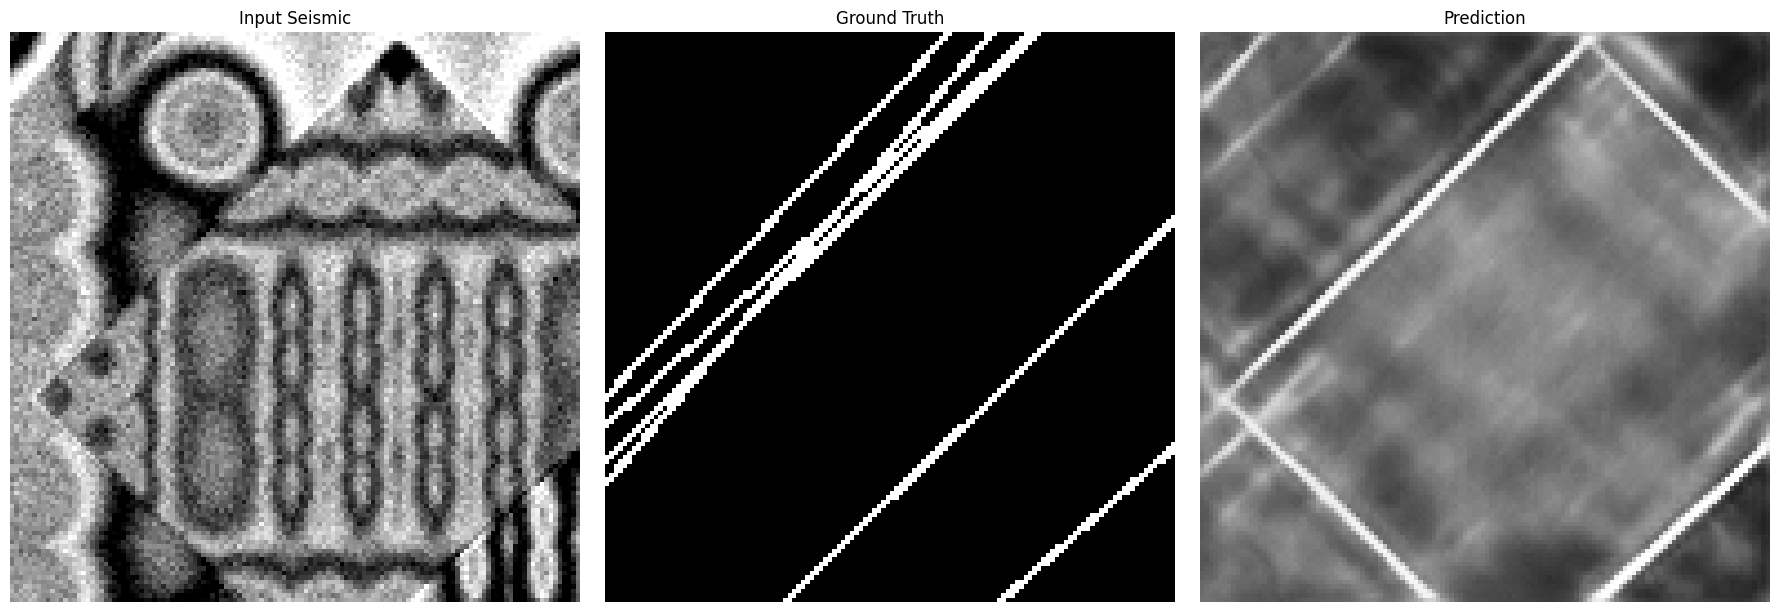

Saved ► train_70_triplet.png

[validation]  Sample → 100


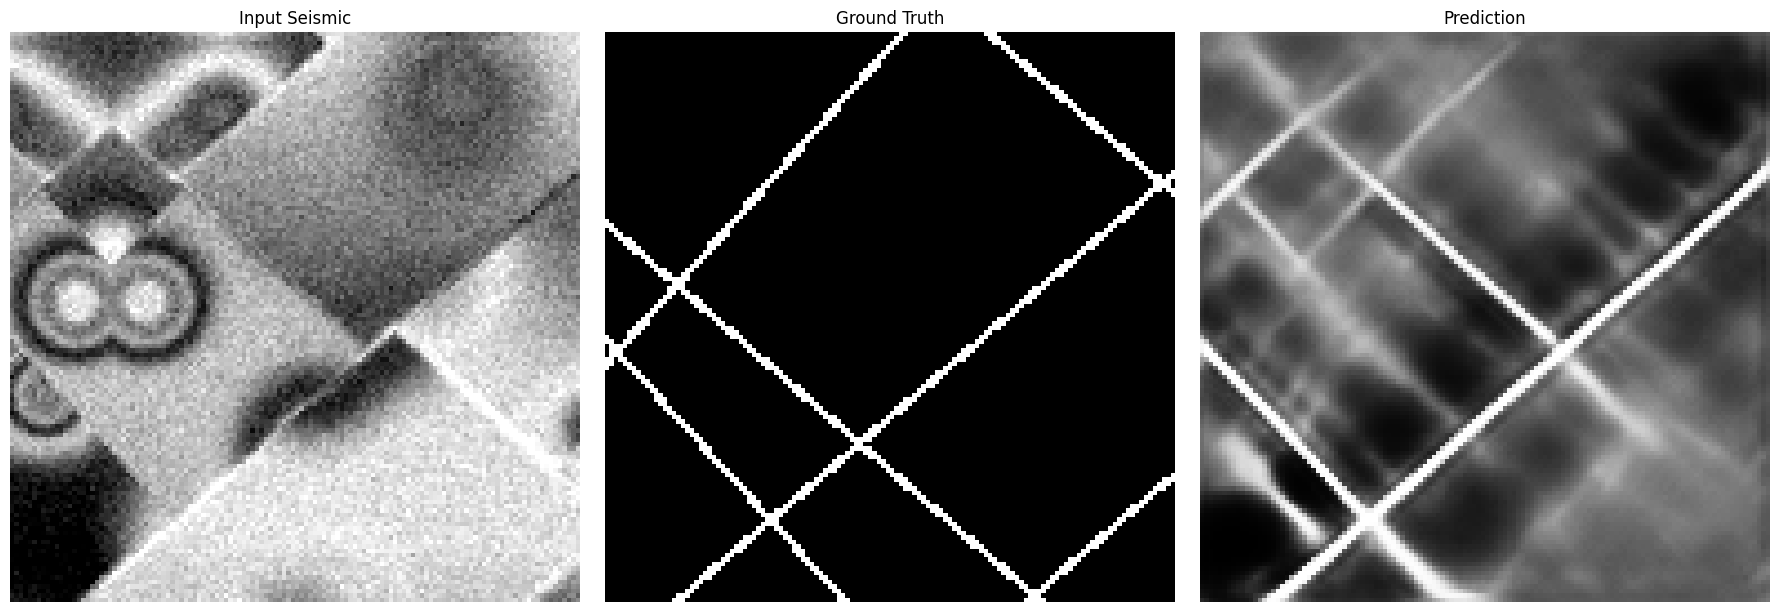

Saved ► validation_100_triplet.png



In [8]:
def show_sample(seis_dir, fault_dir, split_name):          # ← three params
    """Pick a random *.npy* pair from <seis_dir>/<fault_dir> and display it."""
    ids = [os.path.splitext(f)[0] for f in os.listdir(seis_dir)
           if f.endswith(".npy")]
    if not ids:
        print(f"[{split_name}]  No .npy files in {seis_dir}")
        return

    sample_id = np.random.choice(ids)
    print(f"[{split_name}]  Sample → {sample_id}")

    # --- load & preprocess exactly like training -----------------
    gx = np.load(os.path.join(seis_dir,  f"{sample_id}.npy"))
    fx = np.load(os.path.join(fault_dir, f"{sample_id}.npy"))

    gx = (gx - gx.mean()) / (gx.std() + 1e-8)
    gx, fx = gx.transpose(), fx.transpose()        # (128,128,128)

    with torch.no_grad():
        tensor_in  = torch.from_numpy(gx).unsqueeze(0).unsqueeze(0)\
                       .to(device, dtype=torch.float)
        tensor_out = model(tensor_in).squeeze().cpu().numpy()

    # --- plot middle slice --------------------------------------
    k = gx.shape[0] // 2
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    titles   = ["Input Seismic", "Ground Truth", "Prediction"]
    images   = [gx[k],           fx[k],          tensor_out[k]]

    for ax, im, ttl in zip(axs, images, titles):
        ax.imshow(im.T, cmap="gray",
                  vmin=-2 if ttl == "Input Seismic" else 0,
                  vmax= 2 if ttl == "Input Seismic" else 1)
        ax.set_title(ttl); ax.axis("off")

    plt.tight_layout()
    save_name = f"{split_name}_{sample_id}_triplet.png"
    plt.savefig(os.path.join(output_dir, save_name), dpi=300)
    plt.show()
    print(f"Saved ► {save_name}\n")


# --- call for TRAIN and VALID splits ---------------------------
show_sample(train_seis_dir,      train_fault_dir,      "train")
show_sample(validation_seis_dir, validation_fault_dir, "validation")

## Step 5: Complex Prediction on a Large Field Image (Tiling/Patching)

Real-world seismic volumes are much larger than the model's `128x128x128` input size. To handle this, we use a patch-based approach:
1.  **Padding:** The large volume is padded with zeros to ensure it's perfectly divisible by our patch-and-stride logic.
2.  **Tiling:** We slide a `128x128x128` window across the padded volume with a defined overlap.
3.  **Blending:** To avoid sharp edges in the final prediction, we use a Gaussian mask. Predictions in the center of a patch have a higher weight than those at the edges.
4.  **Stitching:** We accumulate the weighted predictions and the weights themselves. The final fault probability at each point is the sum of weighted predictions divided by the sum of weights.

In [9]:
def create_gaussian_mask(overlap_size, n1, n2, n3):
    """Creates a 3D Gaussian mask for smooth blending of patches."""
    sc = np.ones((n1, n2, n3), dtype=np.single)
    sig = overlap_size / 4.0
    sig = 0.5 / (sig * sig)
    
    sp = np.zeros(overlap_size, dtype=np.single)
    for i in range(overlap_size):
        ds = i - overlap_size + 1
        sp[i] = np.exp(-ds * ds * sig)
        
    for i in range(overlap_size):
        sc[i,:,:] *= sp[i]
        sc[n1-1-i,:,:] *= sp[i]
        sc[:,i,:] *= sp[i]
        sc[:,n2-1-i,:] *= sp[i]
        sc[:,:,i] *= sp[i]
        sc[:,:,n3-1-i] *= sp[i]
    return sc

In [10]:
# --- 1. Load Large Seismic Volume ---
f3d_path = os.path.join(prediction_dir_f3d, 'gxl.dat')
m3, m2, m1 = 512, 384, 128
gx = np.fromfile(f3d_path, dtype=np.single).reshape(m3, m2, m1)
print(f"Loaded F3 field data with shape: {gx.shape}")

# --- FIX: Transpose to (xline, inline, depth) to match training data orientation ---
gx = np.transpose(gx)
m1, m2, m3 = gx.shape
print(f"Transposed shape for processing: {gx.shape}")

# --- 2. Setup Tiling Parameters ---
# FIX: Renamed 'os' to 'overlap_size' to avoid conflict with the os module
overlap_size = 12
stride = (patch_n1 - overlap_size, patch_n2 - overlap_size, patch_n3 - overlap_size)

# Calculate padding needed
p1 = (stride[0] - (m1 - patch_n1) % stride[0]) % stride[0] if m1 > patch_n1 else 0
p2 = (stride[1] - (m2 - patch_n2) % stride[1]) % stride[1] if m2 > patch_n2 else 0
p3 = (stride[2] - (m3 - patch_n3) % stride[2]) % stride[2] if m3 > patch_n3 else 0
gp = np.pad(gx, ((0,p1), (0,p2), (0,p3)), mode='constant', constant_values=0)
padded_shape = gp.shape

# --- 3. Initialize Output and Run Prediction Loop ---
gy = np.zeros(padded_shape, dtype=np.single)
mk = np.zeros(padded_shape, dtype=np.single)
sc = create_gaussian_mask(overlap_size, patch_n1, patch_n2, patch_n3)

k1_range = range(0, padded_shape[0] - patch_n1 + 1, stride[0])
k2_range = range(0, padded_shape[1] - patch_n2 + 1, stride[1])
k3_range = range(0, padded_shape[2] - patch_n3 + 1, stride[2])

print("\nStarting tiling prediction on large volume...")
for k1 in tqdm(k1_range, desc="Dim 1/3"):
    for k2 in k2_range:
        for k3 in k3_range:
            patch = gp[k1:k1+patch_n1, k2:k2+patch_n2, k3:k3+patch_n3]
            
            # FIX: Use mean/std normalization PER PATCH to match training
            patch_processed = (patch - np.mean(patch)) / (np.std(patch) + 1e-8)
            
            input_patch = torch.from_numpy(patch_processed).unsqueeze(0).unsqueeze(0).to(device, dtype=torch.float)
            with torch.no_grad():
                predicted_patch_tensor = model(input_patch)
            
            predicted_patch = predicted_patch_tensor.squeeze().cpu().numpy()
            
            gy[k1:k1+patch_n1, k2:k2+patch_n2, k3:k3+patch_n3] += predicted_patch * sc
            mk[k1:k1+patch_n1, k2:k2+patch_n2, k3:k3+patch_n3] += sc

# --- 4. Finalize by Averaging and Cropping ---
gy = np.divide(gy, mk, out=np.zeros_like(gy), where=mk!=0)
fp_final_transposed = gy[:m1, :m2, :m3]

print(f"\nPrediction complete. Final fault probability map shape: {fp_final_transposed.shape}")

output_filename = os.path.join(prediction_dir_f3d, "fp_pytorch.dat")
fp_final_transposed.astype(np.single).tofile(output_filename)
print(f"Final prediction saved to: {output_filename}")

Loaded F3 field data with shape: (512, 384, 128)
Transposed shape for processing: (128, 384, 512)

Starting tiling prediction on large volume...


Dim 1/3:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction complete. Final fault probability map shape: (128, 384, 512)
Final prediction saved to: /home/roderickperez/DS_PROJECTS/faultSeg/data/data_from_Wu/prediction/f3d/fp_pytorch.dat


## Step 6: Visualize the Field Prediction Results

Now we can load the original seismic data and our final fault prediction to compare them visually on different slices.

Seismic cube: (512, 384, 128)   Prediction cube: (512, 384, 128)


/tmp/ipykernel_46078/960170085.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


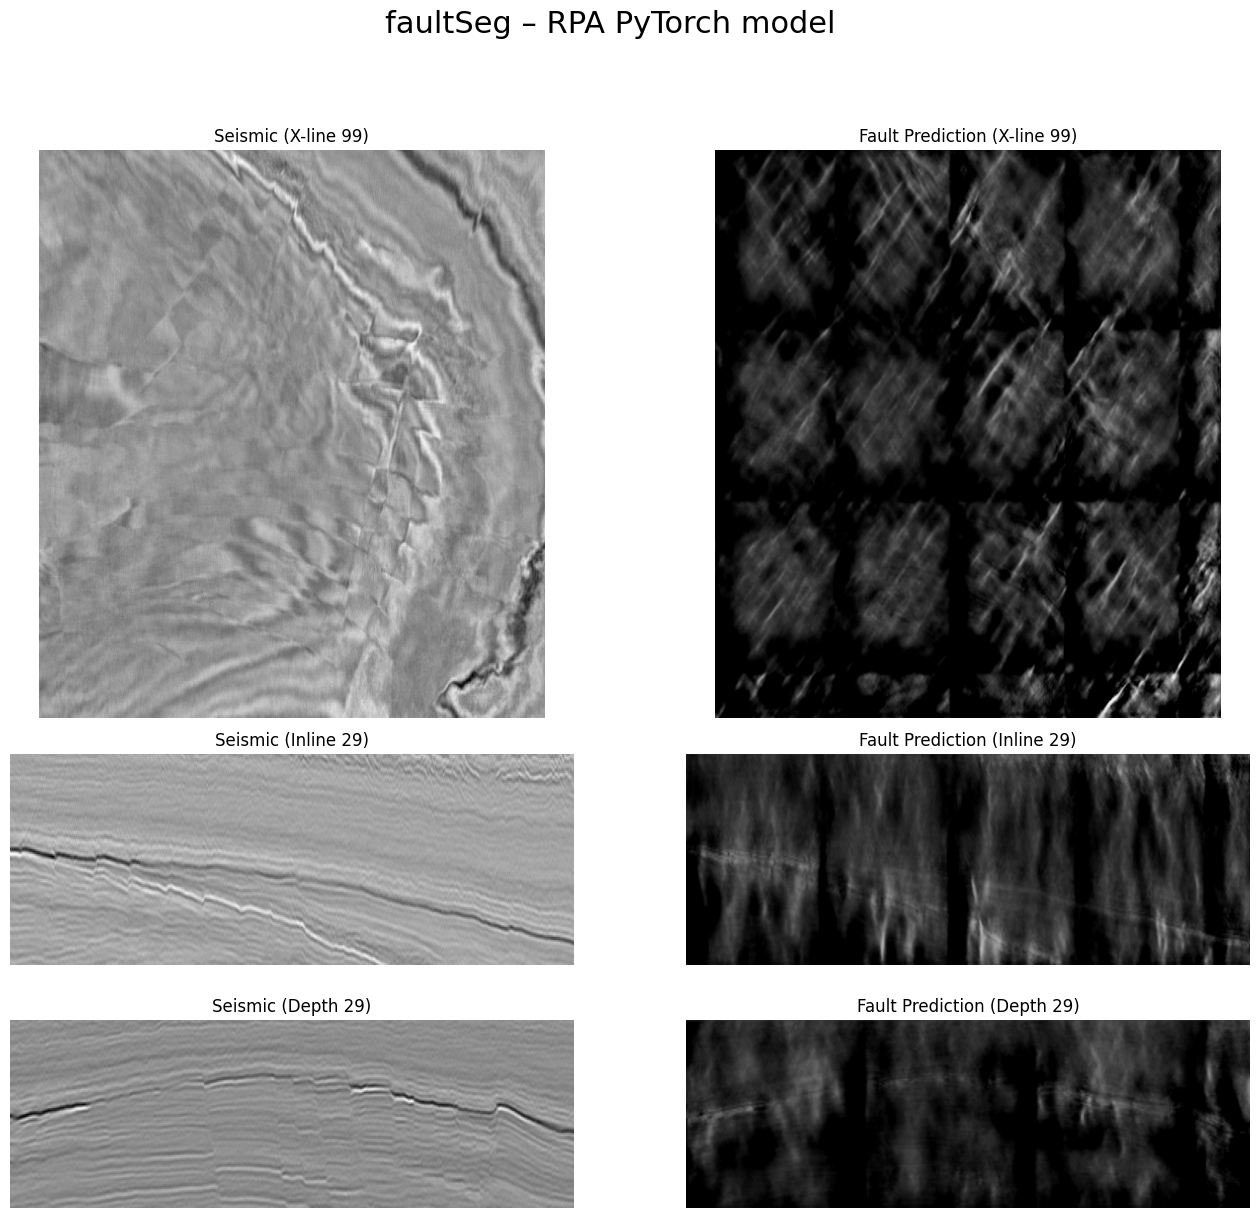

faultSeg results using PyTorch /home/roderickperez/DS_PROJECTS/faultSeg/faultSeg_RPA_V1/output/images/faultSegResultsUsingPyTorch.png


In [11]:
# --------------------------------------------------------------
# Field-volume visualisation  (X-line, Inline, Depth) – PyTorch
# --------------------------------------------------------------
output_dir = os.path.join(ROOT_DIR, "output", "images")
os.makedirs(output_dir, exist_ok=True)

# --- Reload original seismic & prediction arrays ---------------
m3, m2, m1 = 512, 384, 128

seismic_path    = os.path.join(prediction_dir_f3d, "gxl.dat")
gx_orig_view    = np.fromfile(seismic_path, dtype=np.single).reshape(m3, m2, m1)

prediction_path = os.path.join(prediction_dir_f3d, "fp_pytorch.dat")
fp_transposed   = np.fromfile(prediction_path, dtype=np.single).reshape(m1, m2, m3)
fp_orig_view    = fp_transposed.transpose()    # (depth, inline, xline)

print("Seismic cube:", gx_orig_view.shape, "  Prediction cube:", fp_orig_view.shape)

# --- Slice indices ---------------------------------------------
k1_depth, k2_inline, k3_xline = 29, 29, 99

# --- Create the 3×2 figure -------------------------------------
fig, axes = plt.subplots(
    3, 2, figsize=(16, 14),
    gridspec_kw=dict(height_ratios=[1, 0.4, 0.4], hspace=0.08)
)
fig.suptitle("faultSeg – RPA PyTorch model", fontsize=22)

# X-line
gx_xline = gx_orig_view[:, :, k3_xline]
fp_xline = fp_orig_view[:, :, k3_xline]
axes[0, 0].set_title(f"Seismic (X-line {k3_xline})")
axes[0, 0].imshow(gx_xline.T, aspect=1.5, cmap="gray"); axes[0, 0].axis("off")
axes[0, 1].set_title(f"Fault Prediction (X-line {k3_xline})")
axes[0, 1].imshow(fp_xline.T, aspect=1.5, cmap="gray",
                  vmin=0.4, vmax=1.0, interpolation="bilinear"); axes[0, 1].axis("off")

# Inline
gx_inline = gx_orig_view[:, k2_inline, :]
fp_inline = fp_orig_view[:, k2_inline, :]
axes[1, 0].set_title(f"Seismic (Inline {k2_inline})")
axes[1, 0].imshow(gx_inline.T, aspect=1.5, cmap="gray"); axes[1, 0].axis("off")
axes[1, 1].set_title(f"Fault Prediction (Inline {k2_inline})")
axes[1, 1].imshow(fp_inline.T, aspect=1.5, cmap="gray",
                  vmin=0.4, vmax=1.0, interpolation="bilinear"); axes[1, 1].axis("off")

# Depth
gx_depth = gx_orig_view[k1_depth, :, :]
fp_depth = fp_orig_view[k1_depth, :, :]
axes[2, 0].set_title(f"Seismic (Depth {k1_depth})")
axes[2, 0].imshow(gx_depth.T, cmap="gray"); axes[2, 0].axis("off")
axes[2, 1].set_title(f"Fault Prediction (Depth {k1_depth})")
axes[2, 1].imshow(fp_depth.T, cmap="gray",
                  vmin=0.4, vmax=1.0, interpolation="bilinear"); axes[2, 1].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])

multi_save = os.path.join(output_dir, "faultSegResultsUsingPyTorch.png")
plt.savefig(multi_save, dpi=300)
plt.show()
print(f"faultSeg results using PyTorch {multi_save}")
